In [1]:
from src.config import config
import os
img_dir = os.path.join(config["DATA_DIR"], "3D_val_npz")
gts_dir = os.path.join(config["DATA_DIR"], "3D_val_gt_interactive_seg")
output_dir = os.path.join(config["RESULTS_DIR"], "nnint")

Loaded configuration for machine: nora


In [16]:
# get list of processed cases
processed_cases = sorted([f for f in os.listdir(output_dir) if f.endswith(".npz")])
len(processed_cases)

2070

In [17]:
import numpy as np

processed_cases = np.random.choice(processed_cases, 500, replace=False)

In [18]:
from src.eval_metrics import ( 
    compute_multi_class_dsc,
    compute_multi_class_nsd,
)

In [19]:
dscs = []
nsds = []
spacings = []
shapes = []


for i, case_filename in enumerate(processed_cases):
    print(f"Processing {i+1}/{len(processed_cases)}: {case_filename}")
    gt_filepath = os.path.join(gts_dir, case_filename)
    gt_data = np.load(gt_filepath)
    gts = gt_data["gts"]
    spacing = gt_data["spacing"]
    spacings.append(spacing)
    shape = gts.shape
    shapes.append(shape)

    output_filepath = os.path.join(output_dir, case_filename)
    output_data = np.load(output_filepath)
    preds = output_data["segs"]
    
    dsc = compute_multi_class_dsc(gts, preds)
                # compute nsd
    if dsc > 0.2:
        # only compute nsd when dice > 0.2 because NSD is also low when dice is too low
        nsd = compute_multi_class_nsd(gts, preds, spacing)
    else:
        nsd = 0.0  # Assume model performs poor on this sample
    dscs.append(dsc)
    nsds.append(nsd)


Processing 1/500: CT_totalseg-vertebrae_s0446.npz


Processing 2/500: MR_BraTS-T2w_bratsgli_1103.npz
Processing 3/500: CT_TotalSeg_muscles_s0326.npz
Processing 4/500: MR_ProstateT2_NCI-Prostate3T-01-0023.npz
Processing 5/500: US_Cardiac_patient0231_2CH_half_sequence.npz
Processing 6/500: CT_TotalSeg_muscles_s0820.npz
Processing 7/500: US_Cardiac_patient0251_2CH_half_sequence.npz
Processing 8/500: MR_WMH_FLAIR_Utrecht_32.npz
Processing 9/500: MR_BraTS-T1c_bratsgli_0178.npz
Processing 10/500: CT_TotalSeg_muscles_s1029.npz
Processing 11/500: US_Cardiac_patient0194_2CH_half_sequence.npz
Processing 12/500: MR_BraTS-T1n_bratsgli_0656.npz
Processing 13/500: CT_AbdomenAtlas_BDMAP_00003854.npz
Processing 14/500: CT_TotalSeg_muscles_s0608.npz
Processing 15/500: MR_BraTS-T2w_bratsgli_0995.npz
Processing 16/500: CT_LNQ_LymphNode-0064.npz
Processing 17/500: MR_BraTS-T1c_bratsgli_0393.npz
Processing 18/500: MR_Spider_31_t1_ivd.npz
Processing 19/500: MR_BraTS-T2f_bratsgli_0349.npz
Processing 20/500: CT_LungMasks_LUNG1-111.npz
Processing 21/500: US_Car

KeyboardInterrupt: 

In [20]:
modalities = [p[:2] for p in processed_cases]
modalities = modalities[:len(dscs)]

In [23]:
len(dscs), len(nsds), len(modalities), len(spacings), len(shapes)
spacings = spacings[:len(dscs)]
shapes = shapes[:len(dscs)]

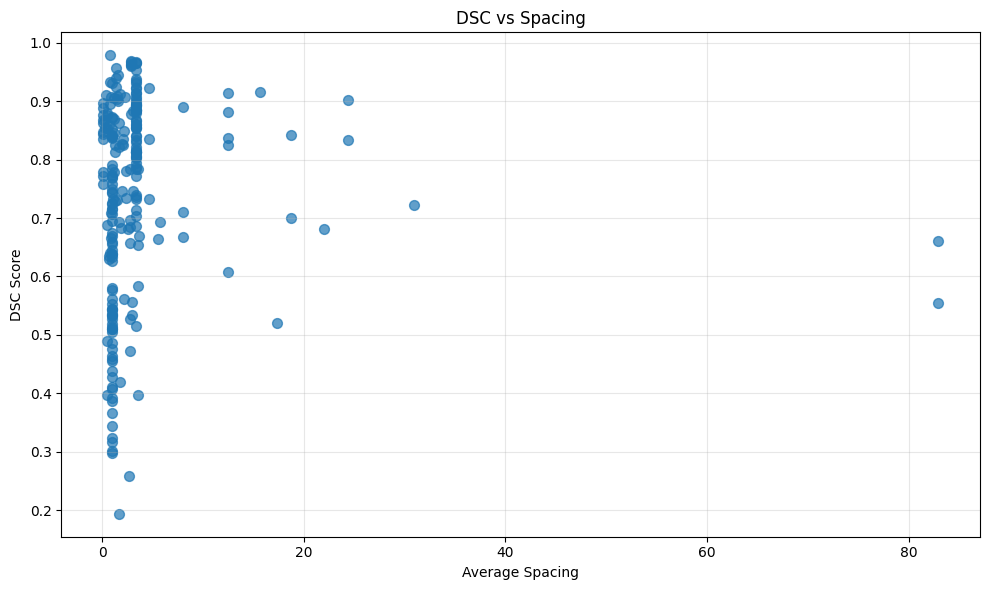

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convert spacings to a comparable metric (average spacing)
voxel_sizes = [np.prod(spacing) for spacing in spacings]
nb_voxels = [np.prod(shape) for shape in shapes]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(voxel_sizes, dscs, alpha=0.7, s=50)

# Add labels and title
plt.xlabel('Average Spacing')
plt.ylabel('DSC Score')
plt.title('DSC vs Spacing')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

In [27]:
def plot_metrics(x_values, dscs, nsds, x_label):
    """Plot DSC and NSD on same graph with shared y-axis"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot DSC (blue) and NSD (red)
    ax.scatter(x_values, dscs, color='blue', alpha=0.7, label='DSC')
    ax.scatter(x_values, nsds, color='red', alpha=0.7, label='NSD')
    
    # Add trend lines
    ax.plot(x_values, np.poly1d(np.polyfit(x_values, dscs, 1))(x_values), 'b--', alpha=0.6)
    ax.plot(x_values, np.poly1d(np.polyfit(x_values, nsds, 1))(x_values), 'r--', alpha=0.6)
    
    # Labels and formatting
    ax.set_xlabel(x_label)
    ax.set_ylabel('Score Value')
    plt.title(f'DSC and NSD vs {x_label}')
    
    # Legend
    ax.legend(loc='best')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print correlation stats
    dsc_corr = np.corrcoef(x_values, dscs)[0,1]
    nsd_corr = np.corrcoef(x_values, nsds)[0,1]
    print(f"DSC correlation with {x_label}: {dsc_corr:.3f}")
    print(f"NSD correlation with {x_label}: {nsd_corr:.3f}")

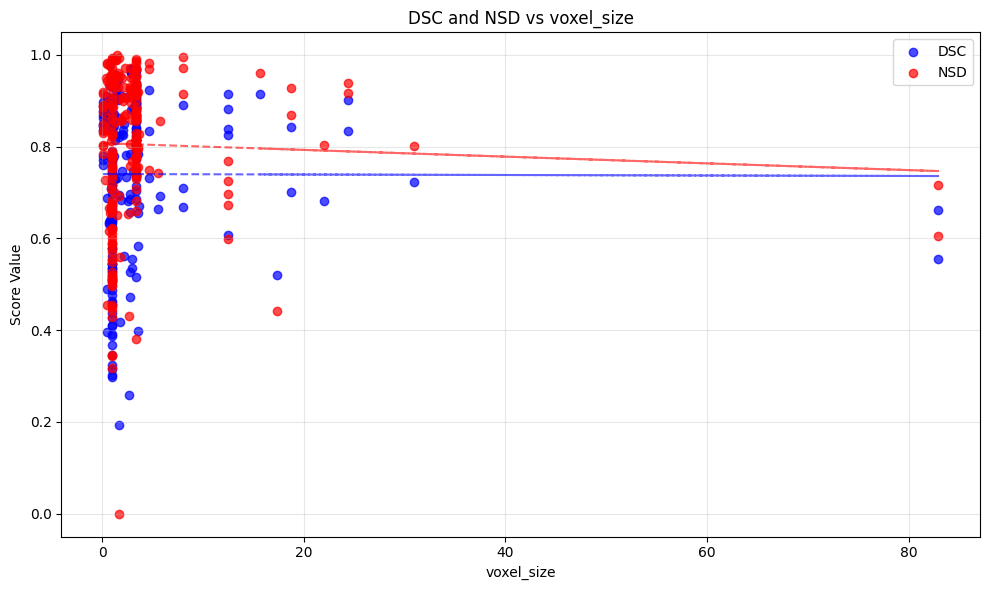

DSC correlation with voxel_size: -0.003
NSD correlation with voxel_size: -0.038


In [28]:
plot_metrics(voxel_sizes, dscs, nsds, 'voxel_size')

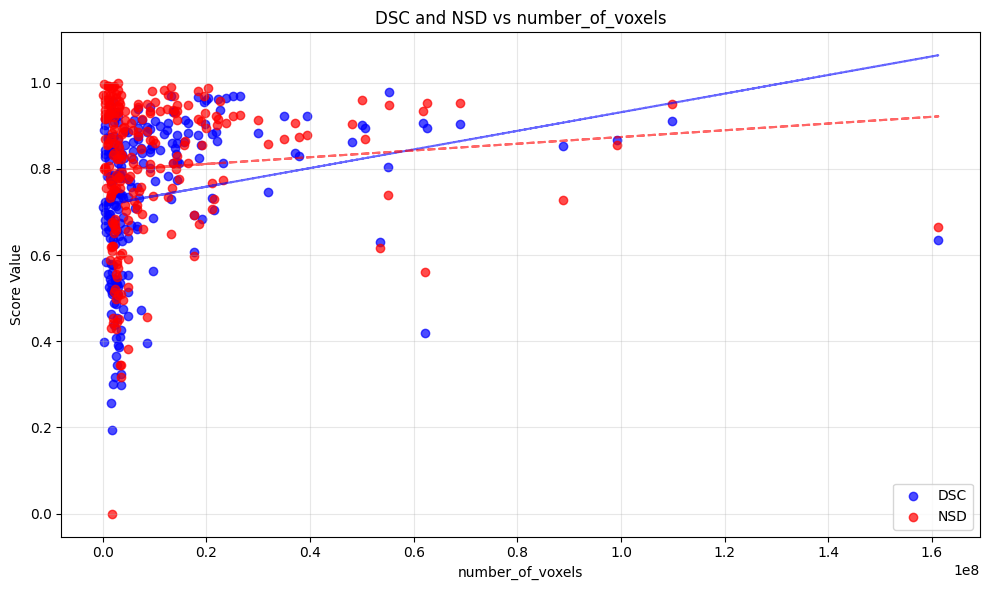

DSC correlation with number_of_voxels: 0.243
NSD correlation with number_of_voxels: 0.092


In [29]:
plot_metrics(nb_voxels, dscs, nsds, 'number_of_voxels')

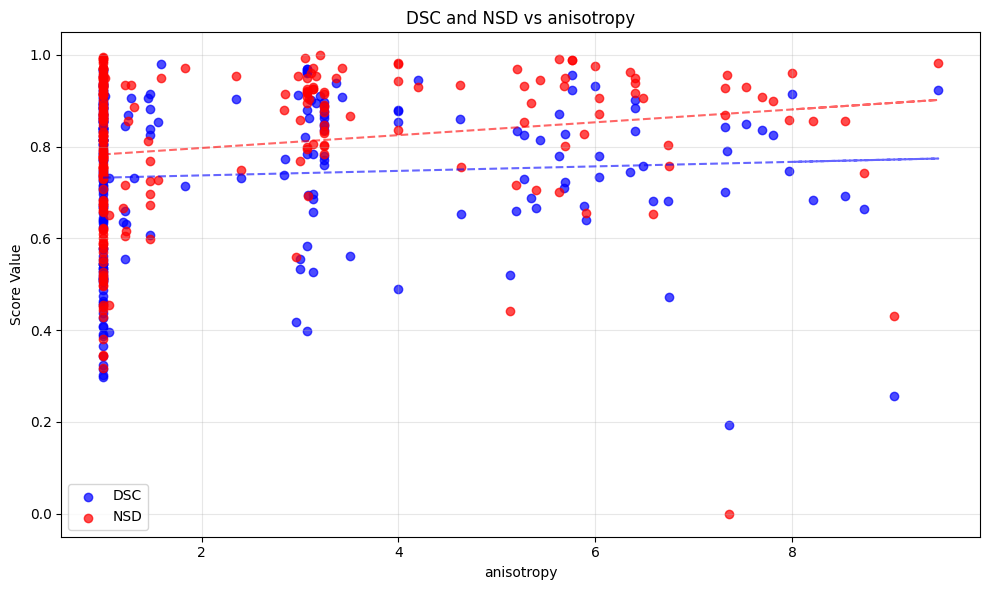

DSC correlation with anisotropy: 0.063
NSD correlation with anisotropy: 0.187


In [30]:
anisotropy = [max(spacing) / min(spacing) for spacing in spacings]
plot_metrics(anisotropy, dscs, nsds, 'anisotropy')

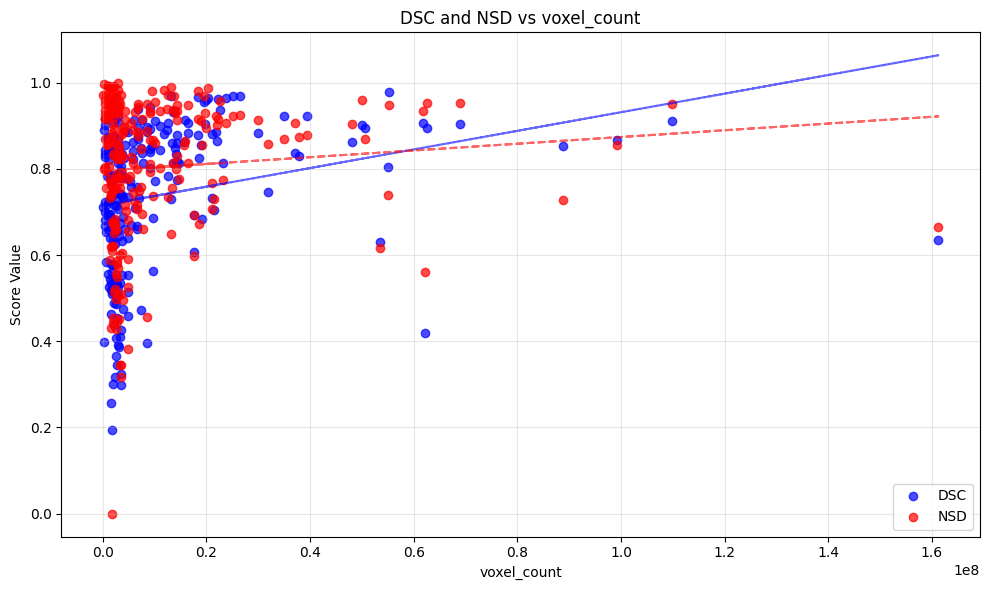

DSC correlation with voxel_count: 0.243
NSD correlation with voxel_count: 0.092


In [31]:
voxel_count = [np.prod(shape) for shape in shapes]
plot_metrics(voxel_count, dscs, nsds, 'voxel_count')

In [33]:
def plot_stats_by_modality(modalities, dscs, nsds, voxel_sizes, voxel_counts):
    """
    Plot statistics by modality with direct modality list input.
    
    Parameters:
    modalities: list of strings - modality for each case (e.g., ['CT', 'MR', 'US', ...])
    dscs: list of floats - DSC values
    nsds: list of floats - NSD values
    voxel_sizes: list of floats - voxel size for each case
    voxel_counts: list of floats - voxel count for each case
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict
    
    # Group metrics by modality
    modality_dscs = defaultdict(list)
    modality_nsds = defaultdict(list)
    modality_voxel_sizes = defaultdict(list)
    modality_voxel_counts = defaultdict(list)
    
    for mod, dsc, nsd, v_size, v_count in zip(modalities, dscs, nsds, voxel_sizes, voxel_counts):
        modality_dscs[mod].append(dsc)
        modality_nsds[mod].append(nsd)
        modality_voxel_sizes[mod].append(v_size)
        modality_voxel_counts[mod].append(v_count)
    
    # Get unique modalities
    unique_mods = sorted(modality_dscs.keys())
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # For boxplots
    metric_data = {
        'DSC': [modality_dscs[mod] for mod in unique_mods],
        'NSD': [modality_nsds[mod] for mod in unique_mods],
        'Voxel Size': [modality_voxel_sizes[mod] for mod in unique_mods],
        'Voxel Count': [modality_voxel_counts[mod] for mod in unique_mods]
    }
    
    titles = ['DSC by Modality', 'NSD by Modality', 
              'Voxel Size by Modality', 'Voxel Count by Modality']
    ylabels = ['DSC Score', 'NSD Score', 'Voxel Size (mmÂ³)', 'Voxel Count']
    
    # Colors for different modalities
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgrey']
    
    # Create each subplot
    for i, (ax, title, ylabel, key) in enumerate(zip(
            axes.flatten(), titles, ylabels, metric_data.keys())):
        
        # Log scale for voxel count
        if key == 'Voxel Count':
            ax.set_yscale('log')
        
        # Create boxplot
        box = ax.boxplot(metric_data[key], patch_artist=True)
        ax.set_xticklabels(unique_mods)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.grid(axis='y', alpha=0.3)
        
        # Add color to boxes
        for j, b in enumerate(box['boxes']):
            b.set(facecolor=colors[j % len(colors)])
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics per modality
    print("Statistics by Modality:")
    print("-----------------------")
    
    for mod in unique_mods:
        print(f"\n{mod} Modality (n={len(modality_dscs[mod])}):")
        print(f"  DSC - Mean: {np.mean(modality_dscs[mod]):.3f}, Median: {np.median(modality_dscs[mod]):.3f}")
        print(f"  NSD - Mean: {np.mean(modality_nsds[mod]):.3f}, Median: {np.median(modality_nsds[mod]):.3f}")
        print(f"  Voxel Size - Mean: {np.mean(modality_voxel_sizes[mod]):.3f}, Median: {np.median(modality_voxel_sizes[mod]):.3f}")
        print(f"  Voxel Count - Mean: {np.mean(modality_voxel_counts[mod]):.3f}, Median: {np.median(modality_voxel_counts[mod]):.3f}")

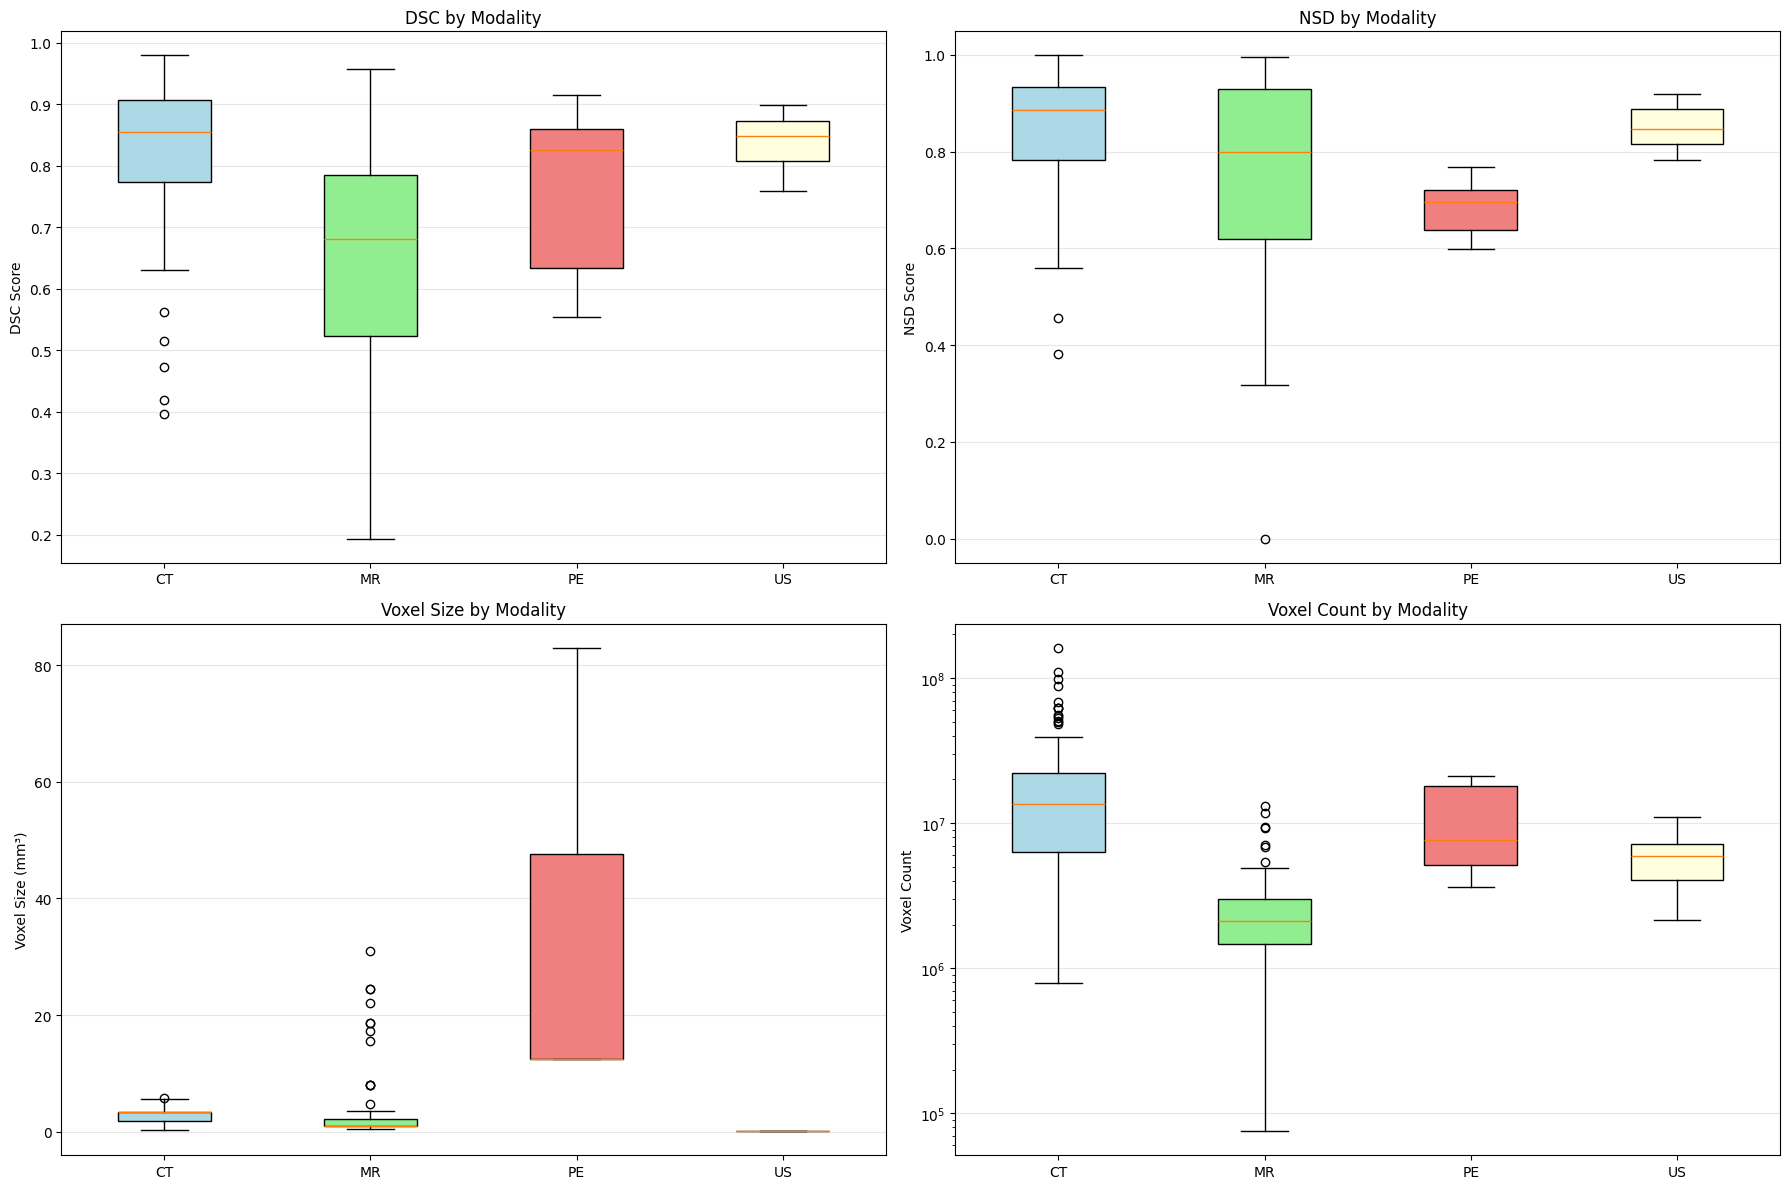

Statistics by Modality:
-----------------------

CT Modality (n=102):
  DSC - Mean: 0.824, Median: 0.855
  NSD - Mean: 0.855, Median: 0.886
  Voxel Size - Mean: 2.707, Median: 3.375
  Voxel Count - Mean: 21163084.353, Median: 13631635.000

MR Modality (n=107):
  DSC - Mean: 0.649, Median: 0.681
  NSD - Mean: 0.760, Median: 0.799
  Voxel Size - Mean: 3.046, Median: 1.000
  Voxel Count - Mean: 2520541.944, Median: 2102828.000

PE Modality (n=7):
  DSC - Mean: 0.754, Median: 0.826
  NSD - Mean: 0.683, Median: 0.696
  Voxel Size - Mean: 32.584, Median: 12.441
  Voxel Count - Mean: 11277531.429, Median: 7680000.000

US Modality (n=11):
  DSC - Mean: 0.839, Median: 0.848
  NSD - Mean: 0.853, Median: 0.847
  Voxel Size - Mean: 0.095, Median: 0.095
  Voxel Count - Mean: 5938103.636, Median: 5908608.000


In [35]:
plot_stats_by_modality(modalities, dscs, nsds, voxel_sizes, voxel_count)
